# Part A Convolution Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import keras_tuner as kt
import visualkeras
from keras.regularizers import l1, l2
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential
from keras.models import Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

## Checking GPU

In [7]:
tf.config.list_physical_devices('GPU')

[]

### Fixing random seed

In [8]:
seed = 69
np.random.seed(seed)

## factors to consider/research

- overfitting (how to prevent it)
    - data augmentation
    - L1 and L2 regulazation
    - dropout layers
    - 
- how does the various parameter of a model (dense layers, parameters of dense layers, activation fucntions, optimizers, learning rate, weigh initilzation, et...)
- affect it eg its accuracy and how does it learn/ will it have vanishing gradient / exploding gradient or any other problems?
- training time and efficiency
    - batch size
- 

## Problem statement
Our problem for this assignment is to create a deep learning model to predict vegatables using the dataset on vegatables.

We need to create 2 seperate final models to predict images on 2 different input sizes:
- 31 x 31
- 128 x128 

## Goals of this project
### Generalise to data well
> To make sure our model is able to generalise to data well, we need to __minimize__ the difference between our training accuracy and test accuracy.
### Accuracy
> In order to minimize avoidable bias, it is important for the model to achieve a training set accuracy of at least __85%__ or higher, which signifies a reasonable level of accuracy.

# Importing Datasets

In [93]:
directory_train = './datasets/Dataset for CA1 part A/train'
directory_test = './datasets/Dataset for CA1 part A/test'
directory_validation = './datasets/Dataset for CA1 part A/validation'

def dataset(directory,image_size,seed=seed):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        image_size=image_size,
        shuffle=True,
        seed=seed,
        batch_size=32
    )
    return dataset

dataset_train_31 = dataset(directory_train,(31,31))
dataset_test_31 = dataset(directory_test,(31,31))
dataset_validation_31 = dataset(directory_validation,(31,31))

dataset_train_128 = dataset(directory_train,(128,128))
dataset_test_128 = dataset(directory_test,(128,128))
dataset_validation_128 = dataset(directory_validation,(128,128))


# print(dataset_test_128._batch_size.numpy())


Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## EDA
What can we get from our EDA?
- How does the average image look like for each class?
- How is the class distribution?
- How does a sample image look like for each class?


In [10]:
class_labels = [
    "Bean",
    "Bitter Gourd",
    "Bottle Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]

### Visualizing our datasets

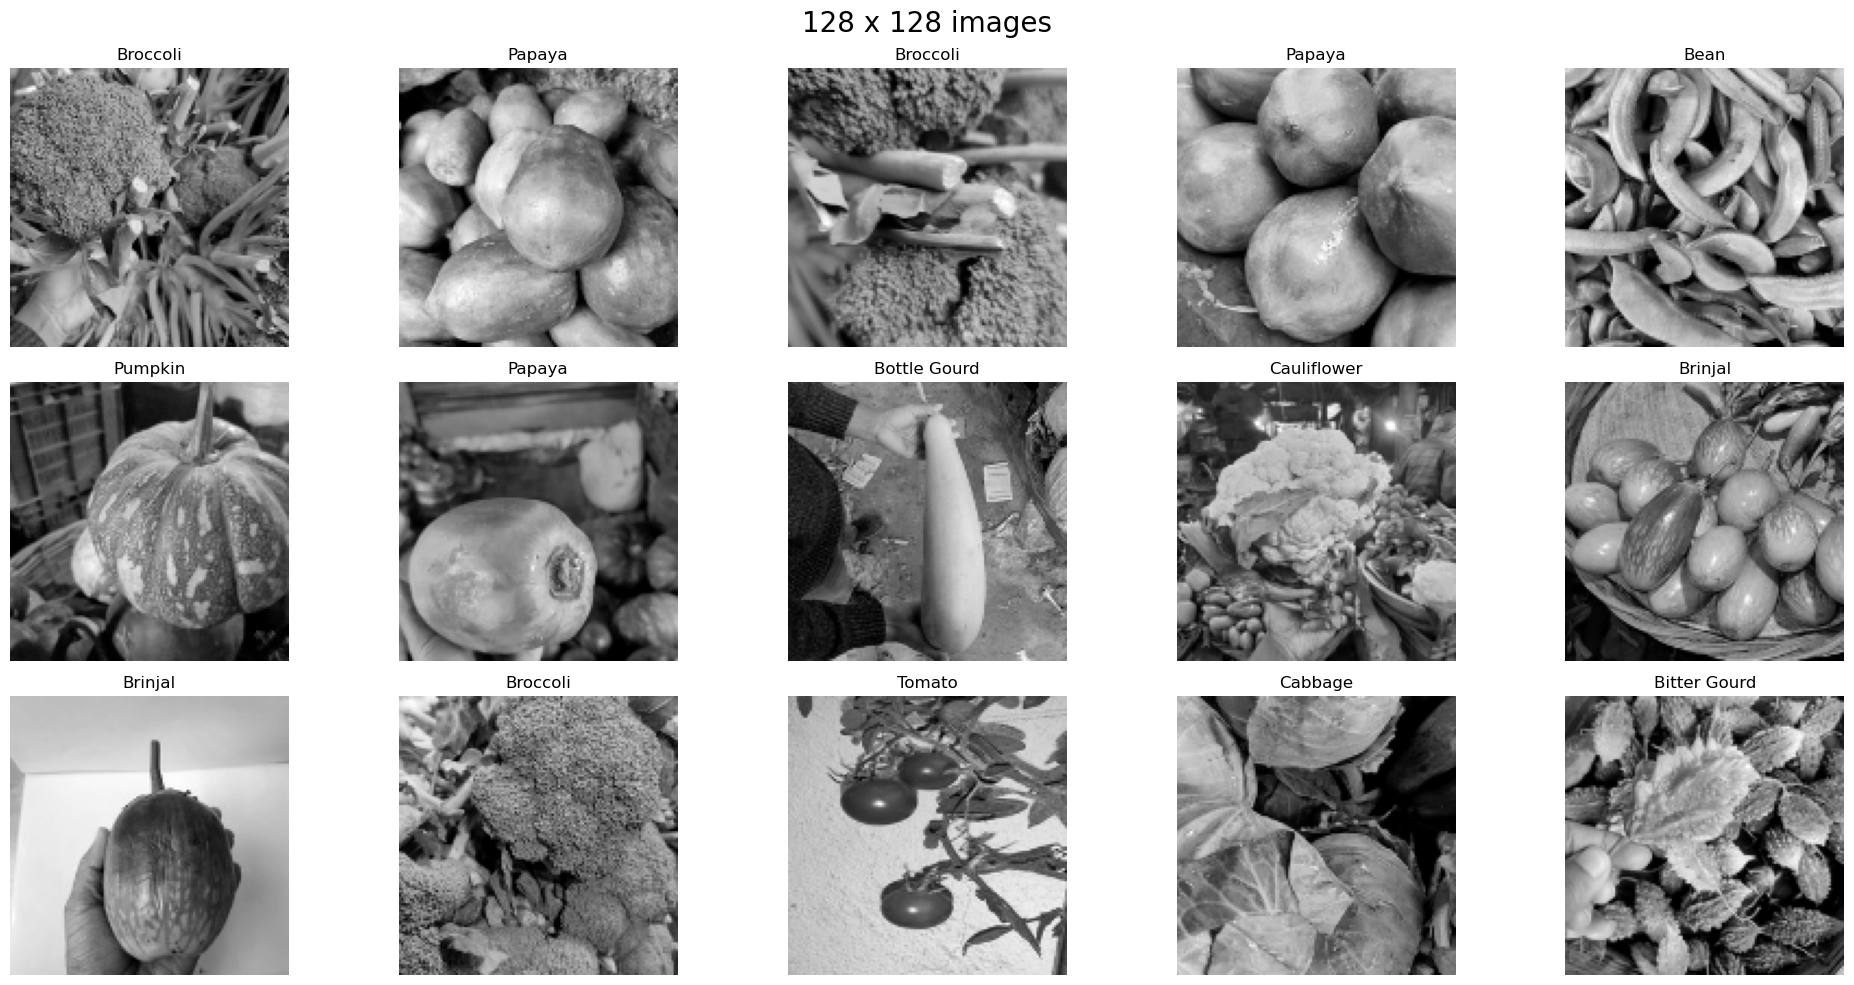

In [48]:
def plot_dataset(dataset, class_labels,title,amtOfPictures):
    n_images = amtOfPictures
    rows = int(np.sqrt(n_images))
    cols = int(np.ceil(n_images / rows))

    i = 0
    plt.figure(figsize=(20, 10))
    plt.suptitle(title, fontsize=20)
    for images, labels in dataset:
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(images.numpy().astype("uint8"),cmap='gray')
        plt.title(class_labels[np.argmax(labels)])
        plt.axis("off")
        i += 1 

        if i >= n_images:
            break
    
    plt.tight_layout()
    plt.show()

plot_dataset(dataset_train_128,class_labels,'128 x 128 images',15)

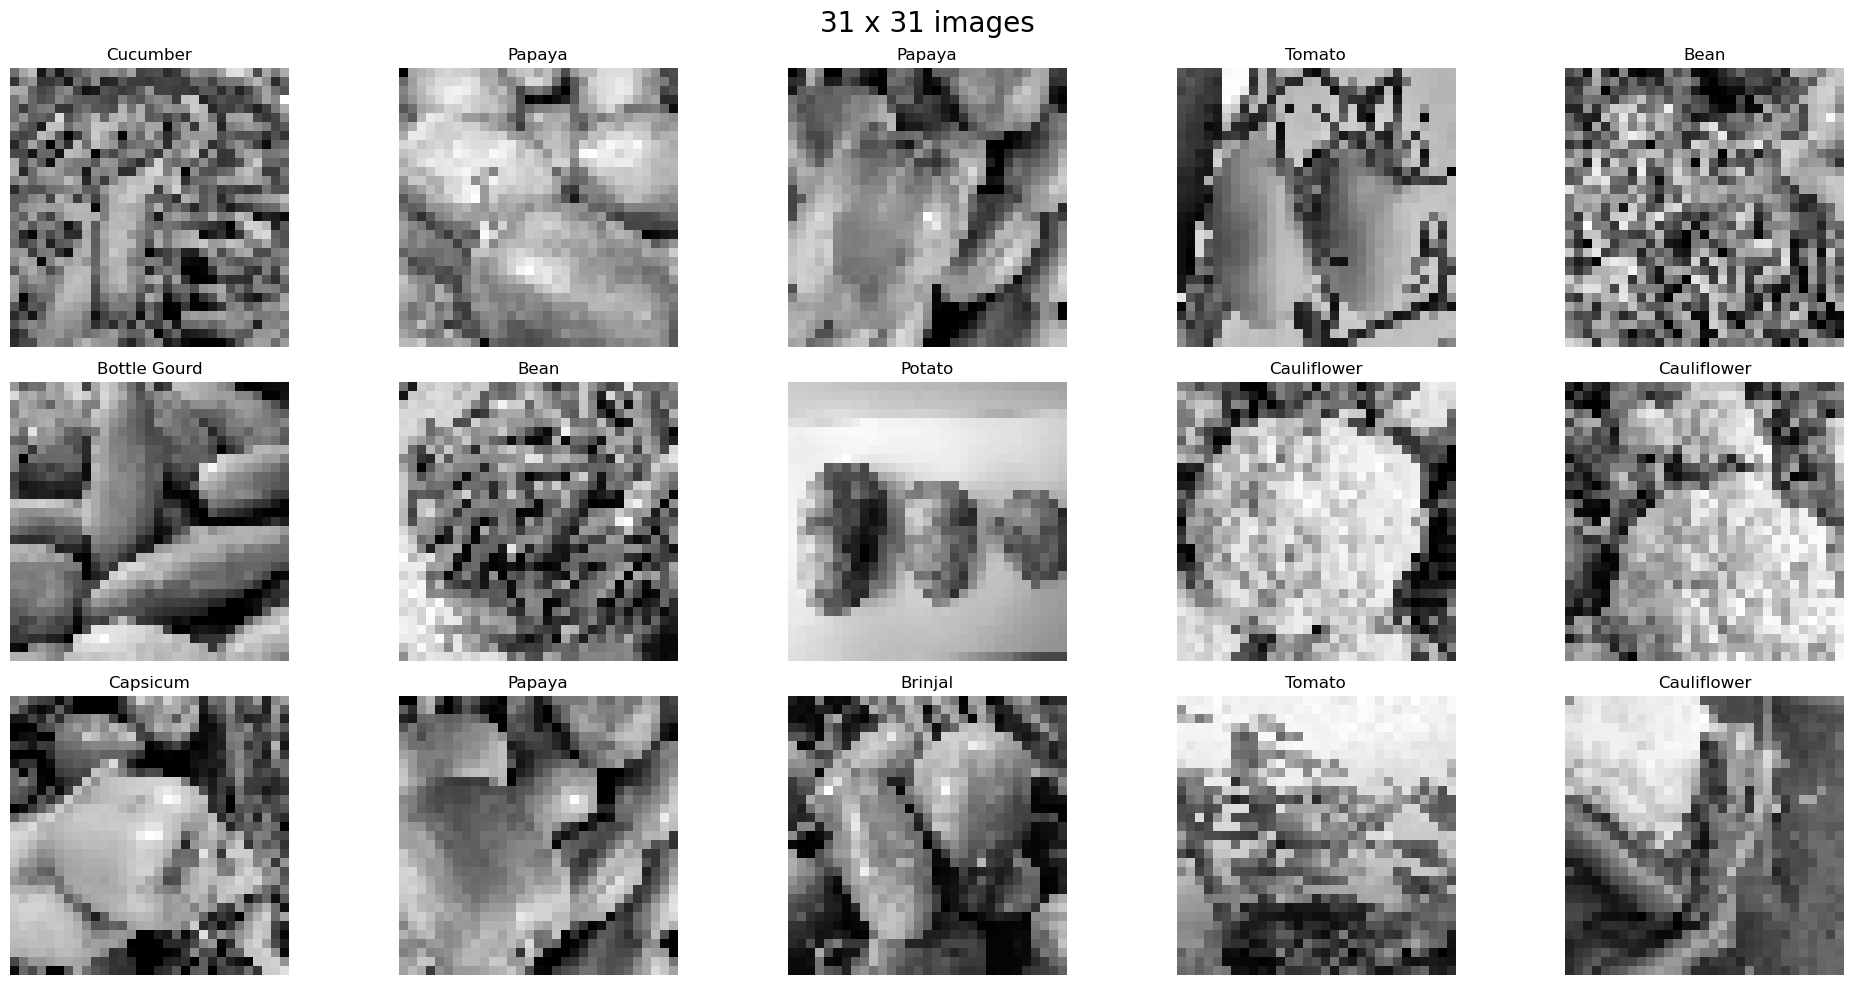

In [49]:
plot_dataset(dataset_train_31,class_labels,'31 x 31 images',15)

Observations:
- We can hardly differentiate between classes for images of size 31x31, hopefully our model can better differeniate these images better than humans!

Now lets get a wider sample range of pictures of every class, to see how diverse the classes are.

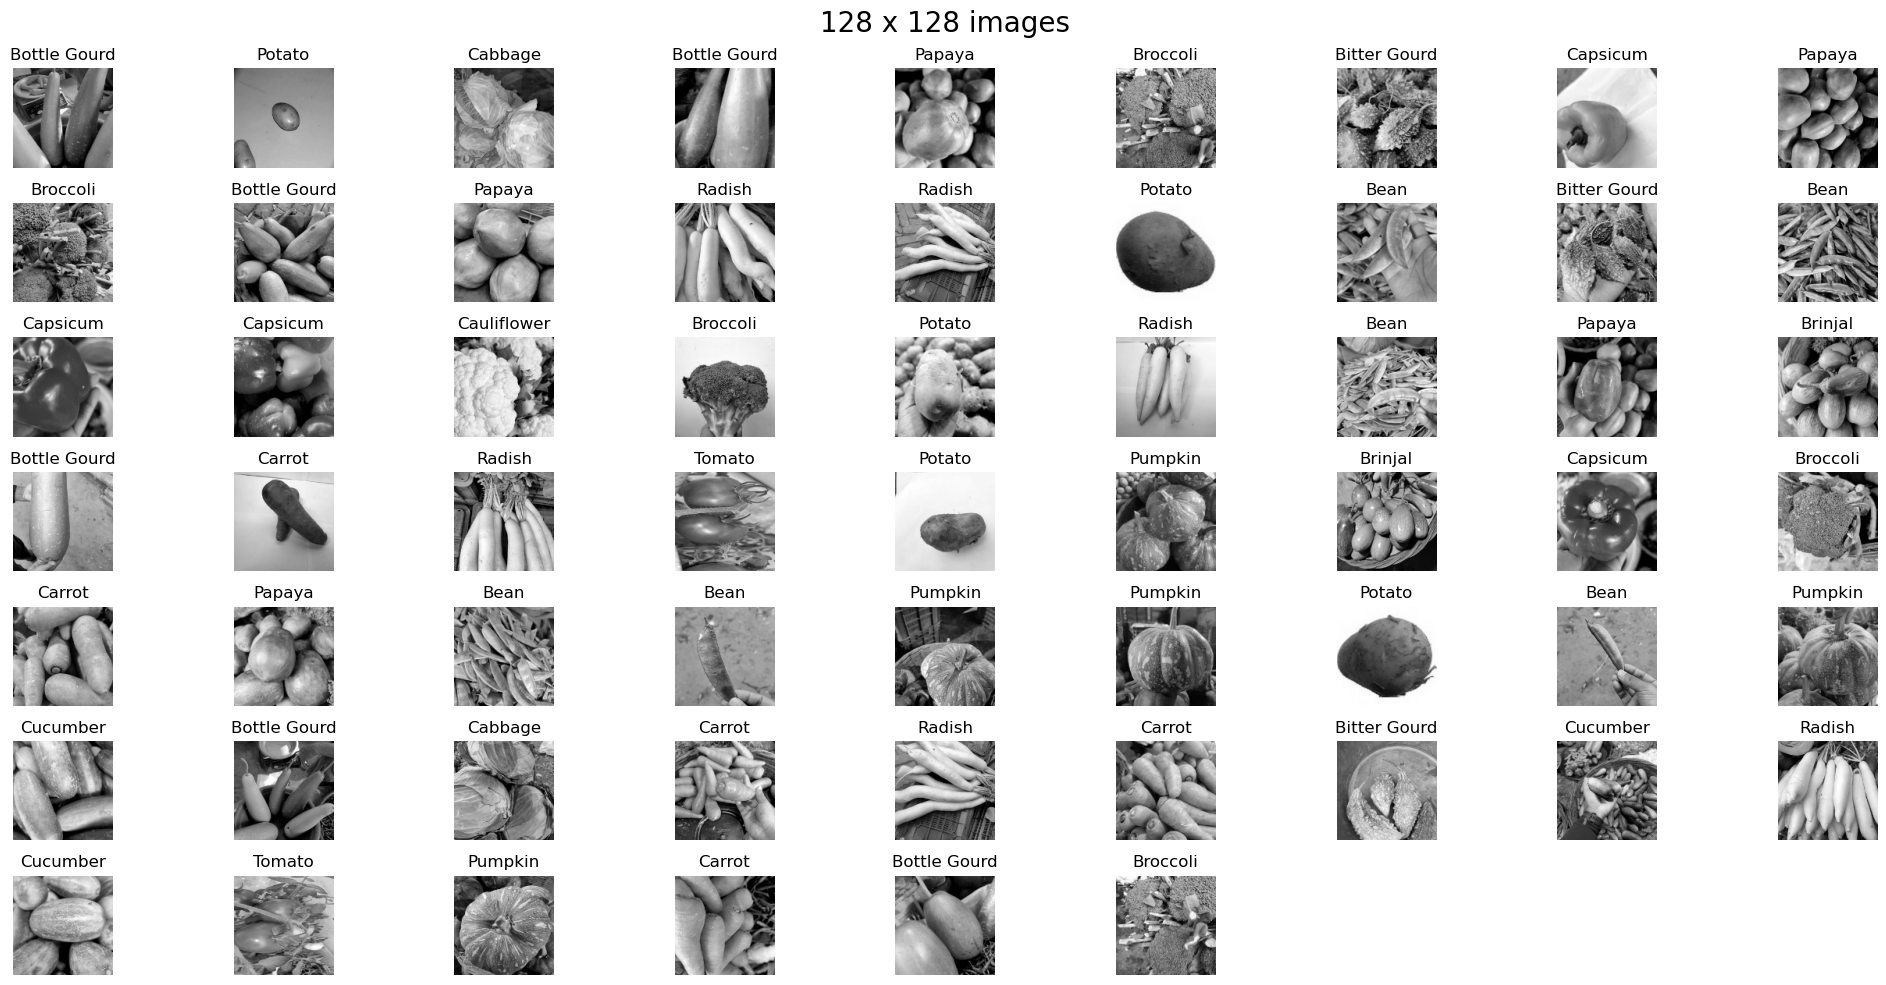

In [51]:
plot_dataset(dataset_test_128,class_labels,'128 x 128 images',60)

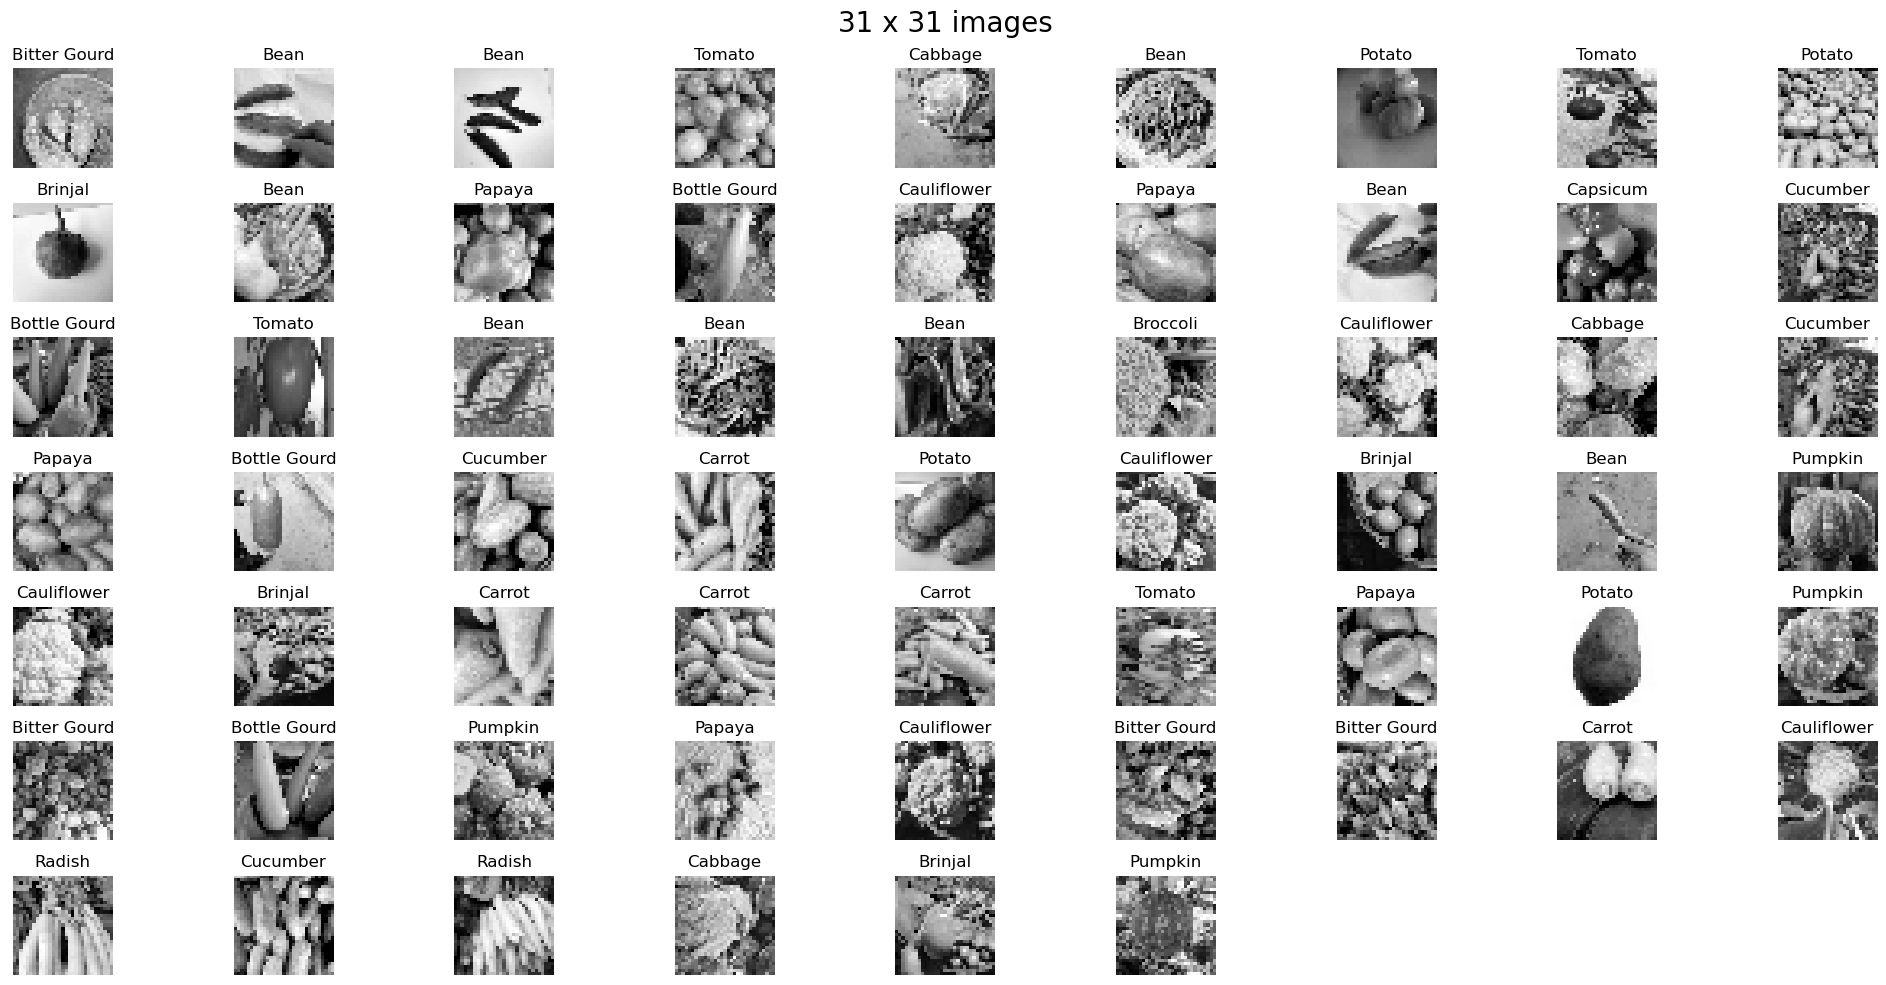

In [52]:
plot_dataset(dataset_test_31,class_labels,'31 x 31 images',60)

### Class Distribution

In [69]:
# class_names  = dataset_train_31.class_names
# num_classes = len(class_names)
# # class_count = {label: 0 for label in class_names}
# # print(class_count)

# class_labels = dataset_train_128.class_names

# # Initialize a dictionary to count the occurrences of each class
# class_count = {label: 0 for label in class_labels}

# # Loop through the dataset to count class occurrences
# for _, labels in dataset_train_128:
#     for label in labels:
#         class_name = class_labels[tf.argmax(label)]
#         class_count[class_name] += 1

# # Create a bar plot to visualize the class distribution
# plt.figure(figsize=(12, 6))
# plt.bar(class_count.keys(), class_count.values())
# plt.xlabel("Class Label")
# plt.ylabel("Count")
# plt.title("Class Distribution")
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()
labels, counts = np.unique(dataset_train_128, return_counts=True)

for label, count in zip(labels, counts):
    print(label, count)
#   print(f"{class_labels[label]}: {count}")

<ShuffleDataset element_spec=(TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None))> 1


AttributeError: 'ShuffleDataset' object has no attribute 'shape'

In [97]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(dataset_train_31, epochs=5, validation_data=dataset_validation_31,batch_size=100)

Epoch 1/5
283/283 [==============================] - 15s 50ms/step - loss: 5.3081 - accuracy: 0.2750 - val_loss: 2.0201 - val_accuracy: 0.3697
Epoch 2/5
283/283 [==============================] - 15s 52ms/step - loss: 1.4875 - accuracy: 0.5246 - val_loss: 1.8244 - val_accuracy: 0.4573
Epoch 3/5
283/283 [==============================] - 16s 55ms/step - loss: 0.9312 - accuracy: 0.7050 - val_loss: 1.8767 - val_accuracy: 0.5107
Epoch 4/5
283/283 [==============================] - 15s 53ms/step - loss: 0.5186 - accuracy: 0.8381 - val_loss: 1.9690 - val_accuracy: 0.5460
Epoch 5/5
283/283 [==============================] - 15s 52ms/step - loss: 0.3392 - accuracy: 0.8938 - val_loss: 2.6342 - val_accuracy: 0.5180


## Data Preprocessing

## Data Augementation


## Models

factors to consider


## Hyperparemeter Tuning

## Final Model